# Vivarium E. coli Composites

Here we demonstrate how to combine the processes in our simulation to demonstrate how they work together.

This tutorial demonstrates how to build composites with the following processes:

1. Transcript initiation + transcript elongation
2. Polypeptide initiation + polypeptide elongation
3. Polypeptide initiation + polypeptide elongation + complexation
    
    
<u>**Future Directions:**</u>
- Demonstrate:
    1. Ecoli master partitioned
    2. Cell division
    3. Vivarium ecoli colonies

<u>**Miscellaneous notes/ideas:**</u>
- consider adding interactive widgets (plotly) - users can click boxes to choose which molecules to plot

In [28]:
# Make sure notebook runs out of vivarium-ecoli directory
import sys, os

# get the path to the notebook, and change working directory
notebook_path = sys.path[0][:sys.path[0].index('notebooks')]
sys.path.append(notebook_path)
os.chdir(sys.path[-1])
cwd = os.getcwd()
  
# print the current directory
# print("Current working directory is:", cwd)

## Load the required components

### Module imports

In [2]:
from vivarium.core.process import Process
from vivarium.core.composer import Composite
from vivarium.core.store import Store
from vivarium.core.engine import Engine, pp
from vivarium.core.composition import simulate_process, simulate_composite
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_variables
from ecoli.processes.registries import topology_registry
import ecoli
import copy

### Load sim_data

This unpickles and `sim_data` object, which holds model parameters from wcEcoli.
`LoadSimData` includes functions to retrieve individual processes' parameters, which can be modified and passed into their respective process models.

In [3]:
from ecoli.library.sim_data import LoadSimData

SIM_DATA_PATH = 'reconstruction/sim_data/kb/simData.cPickle'

load_sim_data = LoadSimData(
            sim_data_path=SIM_DATA_PATH,
            seed=0)

### Get initial state snapshot

`initial_state` is a dict with the initial state of the system -- a snapshot saved from wcEcoli.

In [4]:
from ecoli.composites.ecoli_master import get_state_from_file

INITIAL_STATE_PATH = 'data/wcecoli_t1000.json'

initial_state = get_state_from_file(path=INITIAL_STATE_PATH)

### Helper functions for executing the notebook

In [5]:
schema_keys = Store.schema_keys

def make_port_printout(ports_schema, depth=0, schema_show=5, filler_size=5):
    print_dict = ''
    filler = filler_size * ' '
    for port, schema in ports_schema.items():
        if isinstance(schema, dict):
            schemavars = list(schema.keys())
            if any(var in schemavars for var in schema_keys):
                print_schema = ''
                for k, v in schema.items():
                    print_schema += f'{(depth+1) * filler} {k}: {v}\n'
                print_dict += f'{depth * filler}{port}:\n{print_schema}\n'
            else:
                schema_items = schema.items()
                first_schema = dict(list(schema_items)[:schema_show])
                next_print = make_port_printout(first_schema, depth+1)
                print_dict += f'{port}:\n{next_print}\n'
                if len(schema) > schema_show:
                    print_dict += f'{(depth+1) * filler}'
                    print_dict += f'... skipping {len(schema)-schema_show} schema entries ...'
                    print_dict += f'\n\n'
        else:
            print_dict += f'{filler}{schema}\n'
    return print_dict

def find_increasing(d):
    for key, value in d.items():
        if value[-1] > value[0]:
            return {key: value}
    
def find_decreasing(d):
    for key, value in d.items():
        if value[-1] < value[0]:
            return {key: value}

## Transcript Initiation + Transcript Elongation

Description:

### Transcript Initiation Process

In [7]:
from ecoli.processes.transcript_initiation import TranscriptInitiation

# load in parameters
ti_params = load_sim_data.get_transcript_initiation_config()

# initialize process and topology
transcript_initiation = TranscriptInitiation(ti_params)

ti_topology = topology_registry.access(transcript_initiation.name)

### Transcript Elongation Process

In [8]:
from ecoli.processes.transcript_elongation import TranscriptElongation

# load in parameters
te_params = load_sim_data.get_transcript_elongation_config()

# initialize process and topology
transcript_elongation = TranscriptElongation(te_params)

te_topology = topology_registry.access(transcript_elongation.name)

### Transcript Initiation/Elongation Composite

In [9]:
# generate composite model
tite_composite = Composite({
    'processes': {
        transcript_initiation.name: transcript_initiation,
        transcript_elongation.name: transcript_elongation
    },
    'topology': {
        transcript_initiation.name: ti_topology,
        transcript_elongation.name: te_topology
    }
})

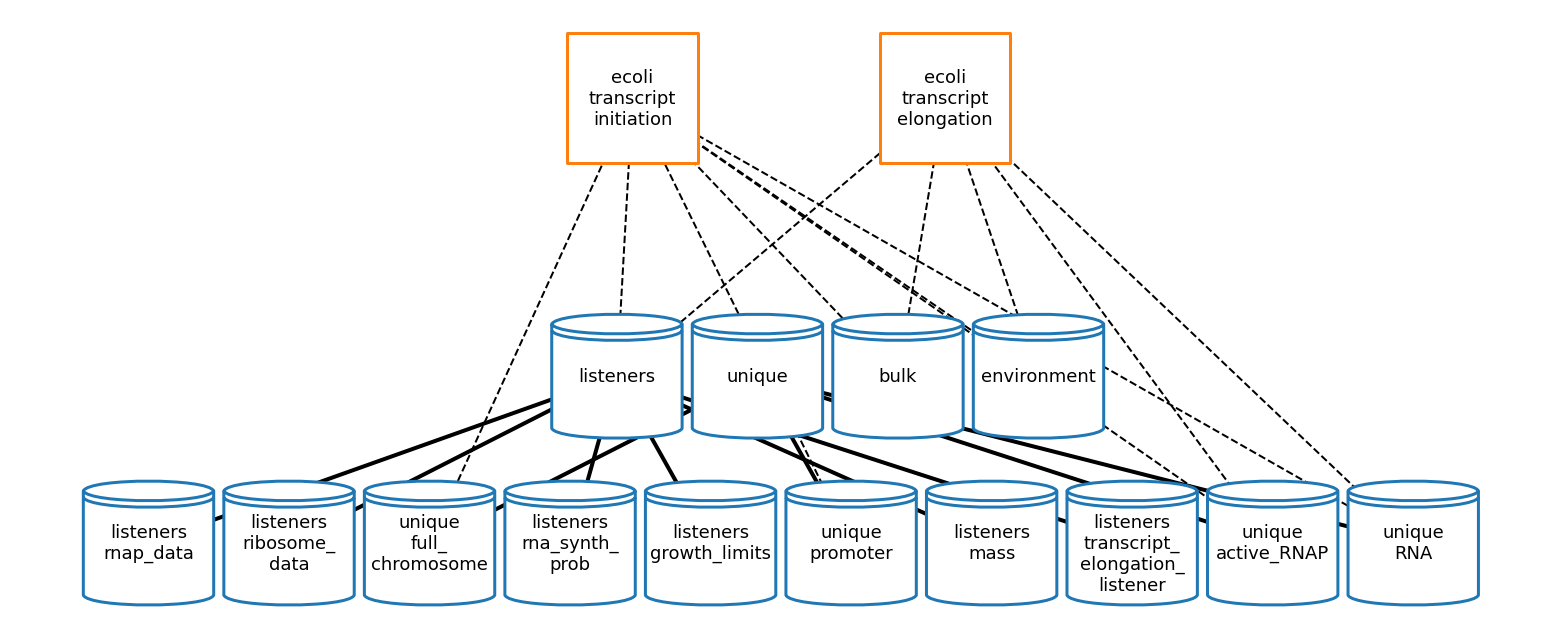

In [10]:
# plot topology
tite_topology_plot_settings = {
    'node_labels': {
        'ecoli-transcript-initiation': 'ecoli\ntranscript\ninitiation',
        'ecoli-transcript-elongation': 'ecoli\ntranscript\nelongation',
        'unique\nfull_chromosome': 'unique\nfull_\nchromosome',
        'listeners\nrna_synth_prob': 'listeners\nrna_synth_\nprob',
        'listeners\nribosome_data': 'listeners\nribosome_\ndata',
        'listeners\ntranscript_elongation_listener': '\nlisteners\ntranscript_\nelongation_\nlistener'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-transcript-initiation': (4, 2),
                    'ecoli-transcript-elongation': (6, 2)}
}

tite_topology_fig = plot_topology(tite_composite, tite_topology_plot_settings)

In [11]:
# run simulation and retrieve final data
tite_settings = {
    'total_time': 10,
    'initial_state': initial_state
    }

tite_data = simulate_composite(tite_composite, tite_settings)


Simulation ID: 4145eed4-2089-11ec-91cf-8c85908ac627
Created: 09/28/2021 at 11:24:02
Completed in 3.67 seconds


In [12]:
# RNA Polymerase binds to and moves along the chromosome
# Depends on ID of RNA Polymerase, which changes with each simulation

pp(tite_data['unique']['active_RNAP'])

{ '00262218957576': {'coordinates': [-502204]},
  '00750247647327': {'coordinates': [-497097]},
  '00769434732279': {'coordinates': [-978472]},
  '00805561876976': {'coordinates': [249612]},
  '00873723249559': {'coordinates': [-502317, -502415]},
  '00915180998890': {'coordinates': [-1107999]},
  '01085856505979': {'coordinates': [-1196415]},
  '01244883260918': {'coordinates': [978663]},
  '01304469187813': {'coordinates': [952723]},
  '01343969780013': {'coordinates': [-1867757]},
  '01414871774787': { 'coordinates': [ 1503387,
                                       1503289,
                                       1503191,
                                       1503093,
                                       1502995]},
  '01564221214771': {'coordinates': [249528]},
  '01609268153116': {'coordinates': [2003120]},
  '01674526127430': {'coordinates': [1280515]},
  '01693361616196': {'coordinates': [1496346]},
  '01771631680730': {'coordinates': [-592740, -592838, -592936]},
  '017718424

                                -1923233,
                                -1923331,
                                -1923429,
                                -1923527,
                                -1923625]},
  '1338333': {'coordinates': [1911797, 1911895, 1911993, 1912091]},
  '1338334': {'coordinates': [1071596, 1071694, 1071792, 1071890]},
  '1338336': {'coordinates': [-1050412]},
  '1338338': { 'coordinates': [ 1874543,
                                1874641,
                                1874739,
                                1874837,
                                1874935,
                                1875033]},
  '1338343': {'coordinates': [1701892, 1701794, 1701696]},
  '1338359': { 'coordinates': [ -1231198,
                                -1231296,
                                -1231394,
                                -1231492,
                                -1231590,
                                -1231688]},
  '1338376': {'coordinates': [-245558]},
  '13383

                                -497783,
                                -497881]},
  '1356604': {'coordinates': [282581, 282679, 282777, 282875, 282973, 283071]},
  '1356607': {'coordinates': [910989, 911087, 911185, 911283, 911381]},
  '1356608': {'coordinates': [-473867, -473965, -474063, -474161]},
  '1356609': {'coordinates': [254994]},
  '1356610': {'coordinates': [-478004]},
  '1356611': {'coordinates': [-475920]},
  '1356612': {'coordinates': [-472883]},
  '1356613': {'coordinates': [-484055]},
  '1356614': {'coordinates': [175244, 175342, 175440, 175538]},
  '1356637': {'coordinates': [111953, 112051, 112149, 112247, 112345, 112443]},
  '1356638': {'coordinates': [111953, 112051, 112149, 112247, 112345, 112443]},
  '1356639': {'coordinates': [243075, 243173, 243271, 243369, 243467, 243565]},
  '1356640': {'coordinates': [18138, 18236, 18334, 18432, 18530, 18628]},
  '1356641': {'coordinates': [284477, 284575, 284673, 284771, 284869, 284967]},
  '1356642': {'coordinates': [2410

  '20794009231383': {'coordinates': [978663]},
  '20841903188871': {'coordinates': [1731507, 1731605]},
  '20844304381857': {'coordinates': [-603701]},
  '20871181453054': {'coordinates': [2064704, 2064606]},
  '20911075060688': {'coordinates': [-1404808]},
  '21067219327546': {'coordinates': [941292]},
  '21210381085080': {'coordinates': [-3419, -3517, -3615, -3713]},
  '21268128271312': {'coordinates': [-1107310]},
  '21395191588896': {'coordinates': [-1407628]},
  '21428421476704': {'coordinates': [-1404686]},
  '21521230256462': {'coordinates': [952723]},
  '21671898496363': {'coordinates': [87193]},
  '21836989454525': {'coordinates': [-1882302]},
  '22300595067589': {'coordinates': [2003414]},
  '22491914842902': {'coordinates': [56515]},
  '22596178544001': {'coordinates': [-1749538, -1749636]},
  '22625098760314': {'coordinates': [1412532]},
  '22666473090491': {'coordinates': [-1881310]},
  '22897746937153': {'coordinates': [-1107585]},
  '22951282579650': {'coordinates': [680

  '94317019767732': {'coordinates': [240799, 240897, 240995, 241093]},
  '94333750607223': {'coordinates': [-1882302]},
  '94707034920799': {'coordinates': [-1107724]},
  '94708662311904': {'coordinates': [680305]},
  '94796514805527': {'coordinates': [-1639648]},
  '94855881245642': {'coordinates': [-1846498]},
  '94940961067333': {'coordinates': [-217167]},
  '94989126324914': {'coordinates': [249612]},
  '95151030448976': {'coordinates': [-607570]},
  '95261094386572': {'coordinates': [1731507, 1731605]},
  '95267652285491': {'coordinates': [284183, 284281, 284379]},
  '95366022808786': {'coordinates': [56515]},
  '95451469377653': {'coordinates': [2003120]},
  '95611096683195': {'coordinates': [1412296]},
  '95698476157217': {'coordinates': [17575]},
  '95737357397992': {'coordinates': [20840, 20938]},
  '95792553438221': {'coordinates': [1343486, 1343584, 1343682, 1343780]},
  '95945591607952': {'coordinates': [-1751293]},
  '95971422760878': {'coordinates': [-1107214]},
  '960279

## Polypeptide Initiation + Polypeptide Elongation

Description:

### Polypeptide Initiation Process

In [15]:
from ecoli.processes.polypeptide_initiation import PolypeptideInitiation

# load in parameters
pi_params = load_sim_data.get_polypeptide_initiation_config()

# initialize process and topology
polypeptide_initiation = PolypeptideInitiation(pi_params)

pi_topology = topology_registry.access(polypeptide_initiation.name)

### Polypeptide Elongation Process

In [16]:
from ecoli.processes.polypeptide_elongation import PolypeptideElongation

# load in parameters
pe_params = load_sim_data.get_polypeptide_elongation_config()

# initialize process and topology
polypeptide_elongation = PolypeptideElongation(pe_params)

pe_topology = topology_registry.access(polypeptide_elongation.name)

### Polypeptide Initiation/Elongation Composite

In [17]:
# generate composite model
pipe_composite = Composite({
    'processes': {
        polypeptide_initiation.name: polypeptide_initiation,
        polypeptide_elongation.name: polypeptide_elongation
    },
    'topology': {
        polypeptide_initiation.name: pi_topology,
        polypeptide_elongation.name: pe_topology
    }
})

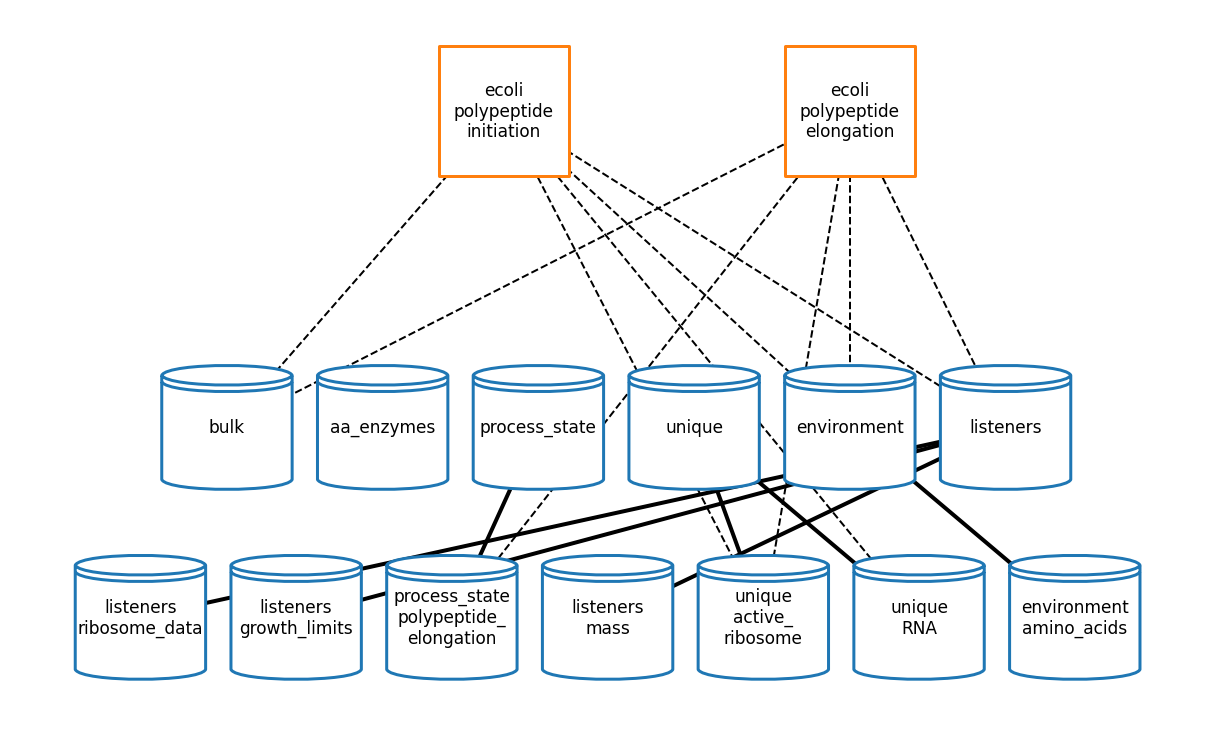

In [18]:
# plot topology
pipe_topology_plot_settings = {
    'node_labels': {
        'ecoli-polypeptide-initiation': 'ecoli\npolypeptide\ninitiation',
        'ecoli-polypeptide-elongation': 'ecoli\npolypeptide\nelongation',
        'unique\nactive_ribosome': 'unique\nactive_\nribosome',
        'process_state\npolypeptide_elongation': 'process_state\npolypeptide_\nelongation'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.8,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-polypeptide-initiation': (3, 2),
                    'ecoli-polypeptide-elongation': (5, 2)}
}

pipe_topology_fig = plot_topology(pipe_composite, pipe_topology_plot_settings)

In [19]:
# run simulation and retrieve final data
pipe_settings = {
    'total_time': 10,
    'initial_state': initial_state
    }

pipe_data = simulate_composite(pipe_composite, pipe_settings)


Simulation ID: 740cd13e-2089-11ec-91cf-8c85908ac627
Created: 09/28/2021 at 11:25:28
Completed in 7.78 seconds


## Polypeptide Initiation + Polypeptide Elongation + Complexation

Description:

In [20]:
from vivarium.core.composer import Composite
from ecoli.processes.polypeptide_initiation import PolypeptideInitiation
from ecoli.processes.polypeptide_elongation import PolypeptideElongation
from ecoli.processes.complexation import Complexation

### Polypeptide Initiation Process

In [21]:
from ecoli.processes.polypeptide_initiation import PolypeptideInitiation

# load in parameters
pi_params = load_sim_data.get_polypeptide_initiation_config()

# initialize process and topology
polypeptide_initiation = PolypeptideInitiation(pi_params)

pi_topology = topology_registry.access(polypeptide_initiation.name)

### Polypeptide Elongation Process

In [22]:
from ecoli.processes.polypeptide_elongation import PolypeptideElongation

# load in parameters
pe_params = load_sim_data.get_polypeptide_elongation_config()

# initialize process and topology
polypeptide_elongation = PolypeptideElongation(pe_params)

pe_topology = topology_registry.access(polypeptide_elongation.name)

### Complexation Process

In [23]:
from ecoli.processes.complexation import Complexation

# load in parameters
cplx_config = load_sim_data.get_complexation_config()

# initialize process and topology
complexation = Complexation(cplx_config)

cplx_topology = topology_registry.access(complexation.name)

### Protein Initiation/Elongation/Complexation Composite

In [24]:
# generate composite model
pipec_composite = Composite({
    'processes': {
        polypeptide_initiation.name: polypeptide_initiation,
        polypeptide_elongation.name: polypeptide_elongation,
        complexation.name: complexation
    },
    'topology': {
        polypeptide_initiation.name: pi_topology,
        polypeptide_elongation.name: pe_topology,
        complexation.name: cplx_topology
    }
})

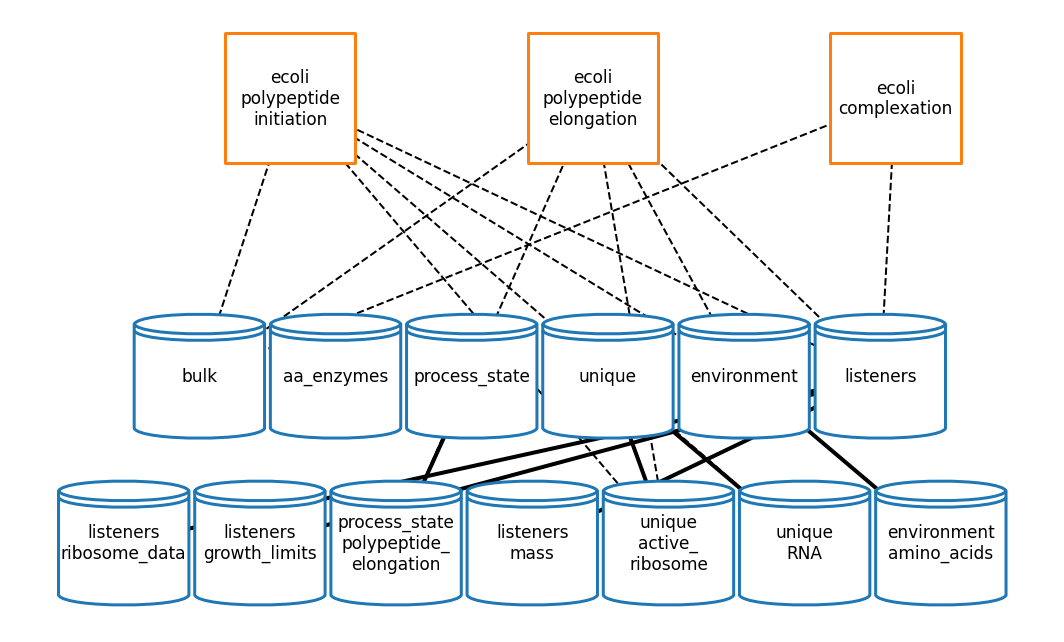

In [25]:
# plot topology
pipec_topology_plot_settings = {
    'node_labels': {
        'ecoli-polypeptide-initiation': 'ecoli\npolypeptide\ninitiation',
        'ecoli-polypeptide-elongation': 'ecoli\npolypeptide\nelongation',
        'ecoli-complexation': 'ecoli\ncomplexation',
        'unique\nactive_ribosome': 'unique\nactive_\nribosome',
        'process_state\npolypeptide_elongation': 'process_state\npolypeptide_\nelongation',
        'uncharged_trna_total': 'uncharged_\ntrna_total',
        'charged_trna_total': 'charged_\ntrna_total',
        'molecules_total': 'molecules_\ntotal',
        'amino_acids_total': 'amino_acids_\ntotal'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-polypeptide-initiation': (2, 2),
                    'ecoli-polypeptide-elongation': (4, 2),
                    'ecoli-complexation': (6, 2)}
}

pipec_topology_fig = plot_topology(pipec_composite, pipec_topology_plot_settings)

In [26]:
# run simulation and retrieve final data
pipec_settings = {
    'total_time': 10,
    'initial_state': initial_state
    }
pipec_data = simulate_composite(pipec_composite, pipec_settings)


Simulation ID: 7b0fe91c-2089-11ec-91cf-8c85908ac627
Created: 09/28/2021 at 11:25:40
Completed in 8.12 seconds


In [27]:
# Initiation: Ribosome attaches to Rna - makes a new unique RNA molecule / new active ribosome
# Elongation: Ribosome moves along the rna / peptide is created (terminated and released as a monomer protein)
# Complexation: monomer gets complexed 

# look through causality network for examples of each component
# point is: all of these processes are happening in the same simulation